In [99]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [100]:
# # row or hight
# fh = 5 
# fw = 4 
# C = 3
# i0 = np.arange(fh) # field hight
# i0, i0.shape
# i0 = np.repeat(i0, fw) # field width
# i0, i0.shape
# i0 = np.tile(i0, C) # C
# i0.shape, i0
# oh = 1
# ow = 2
# i1 = np.repeat(np.arange(oh), ow)
# i1, i1.shape
# i = i0.reshape(-1, 1) + i1.reshape(1, -1)
# i.shape, i1.shape, i0.shape, i1, i0, i[-4:], 
# # i.astype(int)
# i.T.shape, i.T

In [101]:
# # for cols or width
# j0 = np.tile(np.arange(fw), fh * C)
# j1 = np.tile(np.arange(ow), oh)
# j = j0.reshape(-1, 1) + j1.reshape(1, -1)
# j0.shape, j1.shape, j.shape, j0, j1, j[:10]
# j.T.shape, j.T

In [102]:
# k = np.tile(np.arange(C), fh * fw).reshape(-1, 1).T
# k.shape, k

In [103]:
# Convolution impl
# from impl.im2col import *
# or
# import impl.im2col as im2col
# out_height = int(((H + (2 * pad) - kernel_height) / stride) + 1), 
# stride == 1, ALWAYS
# pad == kernel//2, ALWAYS
# kernel == min size ALWAYS, i.e. one past, one pres, one post (if exist), i.e. three or two
# kernel == 3 or 2 ALWAYS
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + (2 * padding) - field_height) % stride == 0
    assert (W + (2 * padding) - field_width) % stride == 0
    out_height = int(((H + (2 * padding) - field_height) / stride) + 1)
    out_width = int(((W + (2 * padding) - field_width) / stride) + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    # j0 = np.tile(np.arange(field_width), field_height * C)
    # or
    j0 = np.tile(np.arange(field_width), field_height)
    j0 = np.tile(j0, C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)
    # or
    # k1 = 1 or np.rashape(-1, 1)
    
    print('k.shape, i.shape, j.shape', k.shape, i.shape, j.shape)

    return (k.astype(int), i.astype(int), j.astype(int))

def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant') # X_NxCxHxW

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    cols = x_padded[:, k, i, j]
    print('cols.shape, X_padded.shape', cols.shape, x_padded.shape)
    
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    print('cols.shape', cols.shape)
    return cols

def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1, stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = x_shape
    H_padded, W_padded = H + (2 * padding), W + (2 * padding)
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    print('cols.shape', cols.shape)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    print('cols_reshaped.shape', cols_reshaped.shape)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped) # slice(None)== ':'
#     np.add.at(x_padded, (:, k, i, j), cols_reshaped) # the same but ERROR
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

def conv_forward(X, W, b, stride=1, padding=1):
    cache = W, b, stride, padding
    n_filters, d_filter, h_filter, w_filter = W.shape
    n_x, d_x, h_x, w_x = X.shape
    h_out = ((h_x + (2 * padding) - h_filter) / stride) + 1
    w_out = ((w_x + (2 * padding) - w_filter) / stride) + 1

    if not h_out.is_integer() or not w_out.is_integer():
        raise Exception('Invalid output dimension!')

    h_out, w_out = int(h_out), int(w_out)

    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    W_col = W.reshape(n_filters, -1)
    print('X_col.shape, W_col.shape', X_col.shape, W_col.shape)

    out = (W_col @ X_col) + b
    out = out.reshape(n_filters, h_out, w_out, n_x)
    out = out.transpose(3, 0, 1, 2)

    cache = (X, W, b, stride, padding, X_col)

    return out, cache

def conv_backward(dout, cache):
    X, W, b, stride, padding, X_col = cache
    n_filter, d_filter, h_filter, w_filter = W.shape

    db = np.sum(dout, axis=(0, 2, 3))
    db = db.reshape(n_filter, -1)

    dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(n_filter, -1)
    dW = dout_reshaped @ X_col.T
    dW = dW.reshape(W.shape)

    W_reshape = W.reshape(n_filter, -1)
    dX_col = W_reshape.T @ dout_reshaped
    dX = col2im_indices(dX_col, X.shape, h_filter, w_filter, padding=padding, stride=stride)

    return dX, dW, db

# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

def selu_forward(X):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
    cache = X
    return out, cache

def selu_backward(dout, cache):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    X = cache
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
    return dX

# p_dropout = keep_prob in this case! 
# Is this true in other cases as well?
def alpha_dropout_fwd(h, q):
    '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    alpha_p = -scale * alpha
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = (mask * h) + ((1 - mask) * alpha_p)
    a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
    b = -a * (1 - q) * alpha_p
    out = (a * dropped) + b
    cache = (a, mask)
    return out, cache

def alpha_dropout_bwd(dout, cache):
    a, mask = cache
    d_dropped = dout * a
    dh = d_dropped * mask
    return dh

In [104]:
# a = np.arange(24).reshape(2,3,4)
# a
# # np.add.at(a, (slice(None), 0, 1, 2), cols_reshaped) # slice(None)== ':'
# # a[:, 0, 1]
# # a[0,:,1] 
# # # or 
# # a[0,slice(None),1],
# # # outputs array([1, 5, 9])

# # a[0,None,1] 
# # a[0, 1]
# # # gives array([[4, 5, 6, 7]])

# # # Could sb explain the latter?

In [105]:
M, D, C = X_train.shape[0], X_train.shape[1], y_train.max() + 1
# M, D, C

X_train, X_val, X_test = prepro(X_train, X_val, X_test)
# X_train.shape, X_val.shape, X_test.shape
# if net_type == 'cnn':
img_shape = (1, 28, 28)
img_shape[:]
# *img_shape
# X_train = X_train.reshape(-1, img_shape[:])
X_train = X_train.reshape(-1, *img_shape)
# X_train = X_train.reshape(-1, img_shape[0], img_shape[1], img_shape[2])
X_val = X_val.reshape(-1, *img_shape)
X_test = X_test.reshape(-1, *img_shape)
X_train.shape, X_val.shape, X_test.shape
# X_train[0, :10, :10, :10]

((55000, 1, 28, 28), (5000, 1, 28, 28), (10000, 1, 28, 28))

In [106]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class CNN:

    def __init__(self, D, C, H, L, p_dropout): #, lam):
        self.mode = 'classification'
        self.L = L # number of layers or depth
        self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[]} #, 'valid'}
#         self.lam = lam
        
        # Model parameters: weights and biases
        # Input layer of Conv
        self.model = []
        self.model.append(dict(
            W1=np.random.randn(H, 1, 3, 3) / np.sqrt(H / 2.),
            b1=np.zeros((H, 1)),
        ))
        
        # Hidden layers of Conv-bn-relu-dropout
        m = []
        for _ in range(self.L):
            m.append(dict(
                W2=np.random.randn(H, H, 3, 3) / np.sqrt(H / 2.),
                b2=np.zeros((H, 1)),
            ))
        self.model.append(m) # self.model[0][]
        
        # Output layer of FC to output
        self.model.append(dict(
            W3=np.random.randn(H*D, C) / np.sqrt(H*D / 2.),
            b3=np.zeros((1, C))
        ))

    def forward(self, X, train):
        # 1st layer - Input layer: X
        X, X_conv_cache = conv_forward(X=X, W=self.model[0]['W1'], b=self.model[0]['b1'])
        X_cache = X_conv_cache

        # 2nd layers - Hidden layers: h
        h_cache = []
        for layer in range(self.L):
            h, h_conv_cache = conv_forward(X=X, W=self.model[1][layer]['W2'], b=self.model[1][layer]['b2'])
            h, h_nl_cache = selu_forward(X=h)
            h += X # residual connection
            if train: 
                # h_do_cache = None # ERROR: referenced before assigned?
                h, h_do_cache = alpha_dropout_fwd(h=h, q=self.p_dropout)
                cache = (h_conv_cache, h_nl_cache, h_do_cache)
            else:
                cache = (h_conv_cache, h_nl_cache)
            h_cache.append(cache)
            
        # 3rd layer - Output layer: y
        y = h.reshape([X.shape[0], -1]) # flattening
        y, y_fc_cache = l.fc_forward(X=y, W=self.model[2]['W3'], b=self.model[2]['b3'])
        y_cache = X, y_fc_cache

        cache = (X_cache, h_cache, y_cache)
        
        return y, cache

    def loss_function(self, y, y_train):
        loss = cross_entropy(y, y_train)
        dy = dcross_entropy(y, y_train)
        return loss, dy
    
    def backward(self, dy, cache):
        X_cache, h_cache, y_cache = cache

        # 3rd layer: Ouput layer y
        X, y_fc_cache = y_cache
        dy, dw3, db3 = l.fc_backward(dout=dy, cache=y_fc_cache)
        dy = dy.reshape([-1, *X.shape[1:4]])
        
        # 2nd layers: Hidden layers h
        g = []
        for layer in reversed(range(self.L)):
            # if train: There is no backward in testing/prediction
            h_conv_cache, h_nl_cache, h_do_cache = h_cache[layer]
            dy = alpha_dropout_bwd(dout=dy, cache=h_do_cache)
            dh = selu_backward(dout=dy, cache=h_nl_cache)
            dh, dw2, db2 = conv_backward(dout=dh, cache=h_conv_cache)
            dh += dy
            g.append(dict(
                    W2=dw2,
                    b2=db2
                    ))
            
        # 1st layer: Input layer X
        X_conv_cache = X_cache
        dX, dw1, db1 = conv_backward(dout=dh, cache=X_conv_cache)

        # grad for GD
        grad = []
        
        # Input layer to conv layer
        grad.append(dict(
            W1=dw1, 
            b1=db1
        ))
        
        # Hidden layers of conv-bn-nl/relu-dropout/do
        grad.append(g)
        
        # Output later to FC layer
        grad.append(dict(
            W3=dw3, 
            b3=db3
        ))
        
        return dX, grad
    
    def test(self, X):
        y_logit, cache = self.forward(X, train=False)
        y_prob = l.softmax(y_logit)
        if self.mode == 'classification':
            return np.argmax(y_prob, axis=1)
        else: # self.mode == 'regression'
            return np.round(y_logit)
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, X_train, y_train, val_set, alpha, mb_size, n_iter, print_after):
        if val_set:
            X_val, y_val = val_set

        M, R = [], []
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        beta1 = .99
        beta2 = .999
        smooth_train = 1.

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            y, cache = self.forward(X_mini, train=True)
            loss, dy = self.loss_function(y, y_mini)
            _, grad = self.backward(dy, cache)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)

            for key in grad[0]:
                M[0][key] = l.exp_running_avg(M[0][key], grad[0][key], beta1)
                R[0][key] = l.exp_running_avg(R[0][key], grad[0][key]**2, beta2)

                m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                r_k_hat = R[0][key] / (1. - (beta2**(iter)))

                self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            for layer in range(self.L):
                for key in grad[1][layer]:
                    M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grad[1][layer][key], beta1)
                    R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grad[1][layer][key]**2, beta2)

                    m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))

                    self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            for key in grad[2]:
                M[2][key] = l.exp_running_avg(M[2][key], grad[2][key], beta1)
                R[2][key] = l.exp_running_avg(R[2][key], grad[2][key]**2, beta2)

                m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                r_k_hat = R[2][key] / (1. - (beta2**(iter)))

                self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Epochs
            if iter % print_after == 0:
                if val_set:
                    val_acc = l.accuracy(y_val, self.test(X_val))
                    print('Iter-{} training loss: {:.4f} validation accuracy: {:4f}'.format(iter, loss, val_acc))

k.shape, i.shape, j.shape (9, 1) (9, 784) (9, 784)
cols.shape, X_padded.shape (64, 9, 784) (64, 1, 30, 30)
cols.shape (9, 50176)
X_col.shape, W_col.shape (9, 50176) (1, 9)
k.shape, i.shape, j.shape (9, 1) (9, 784) (9, 784)
cols.shape, X_padded.shape (64, 9, 784) (64, 1, 30, 30)
cols.shape (9, 50176)
X_col.shape, W_col.shape (9, 50176) (1, 9)
k.shape, i.shape, j.shape (9, 1) (9, 784) (9, 784)
cols.shape (9, 50176)
cols_reshaped.shape (64, 9, 784)
k.shape, i.shape, j.shape (9, 1) (9, 784) (9, 784)
cols.shape (9, 50176)
cols_reshaped.shape (64, 9, 784)
k.shape, i.shape, j.shape (9, 1) (9, 784) (9, 784)
cols.shape, X_padded.shape (5000, 9, 784) (5000, 1, 30, 30)
cols.shape (9, 3920000)
X_col.shape, W_col.shape (9, 3920000) (1, 9)
k.shape, i.shape, j.shape (9, 1) (9, 784) (9, 784)
cols.shape, X_padded.shape (5000, 9, 784) (5000, 1, 30, 30)
cols.shape (9, 3920000)
X_col.shape, W_col.shape (9, 3920000) (1, 9)
Iter-1 training loss: 4.8501 validation accuracy: 0.112600


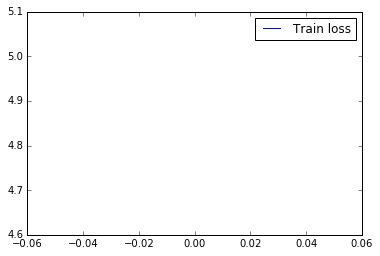

In [107]:
# Hyper-parameters
n_iter = 1 # number of epochs
alpha = 1e-4 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
num_layers = 1 # depth 
print_after = 1 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 1
# num_input_units = # noise added at the input lavel
p_dropout = 0.95 #  keep_prob = p_dropout, q = 1-p, 0.95 or 0.90 by default, noise at the network level or layers
lam = 1e-3 # reg at the feedback or loss function or function loss level as noise or loss_reg added.

# Build the model/NN and learn it: running session.
nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

# # Kernel dead problem
# y_pred = nn.test(X_test)
# accs = np.mean(y_pred == y_test)
# print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()